# XG model - Statsbomb style
We want to build a xG model starting from the Statsbomb data on 16 years of data of La Liga.

In [1]:
import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mplsoccer.pitch import Pitch
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as cbar

from sklearn.metrics import log_loss

pd.set_option('display.max_columns', 200)
pd.set_option('mode.chained_assignment', None)

In [2]:
data_path = '/Users/mfelici/personal_projects/football/data/statsbomb/open-data/data/'

#### Load competitions

In [3]:
competitions = pd.read_json(os.path.join(data_path, 'competitions.json'))
competitions = competitions.loc[competitions['competition_name'] == 'La Liga']

print(competitions.shape)
competitions

(16, 8)


,competition_id,season_id,country_name,competition_name,competition_gender,season_name,match_updated,match_available
18,11,42,Spain,La Liga,male,2019/2020,2020-12-18T12:10:38.985394,2020-12-18T12:10:38.985394
19,11,4,Spain,La Liga,male,2018/2019,2020-07-29T05:00,2020-07-29T05:00
20,11,1,Spain,La Liga,male,2017/2018,2020-07-29T05:00,2020-07-29T05:00
21,11,2,Spain,La Liga,male,2016/2017,2021-02-02T23:24:58.985975,2021-02-02T23:24:58.985975
22,11,27,Spain,La Liga,male,2015/2016,2020-07-29T05:00,2020-07-29T05:00
23,11,26,Spain,La Liga,male,2014/2015,2020-07-29T05:00,2020-07-29T05:00
24,11,25,Spain,La Liga,male,2013/2014,2020-07-29T05:00,2020-07-29T05:00
25,11,24,Spain,La Liga,male,2012/2013,2020-07-29T05:00,2020-07-29T05:00
26,11,23,Spain,La Liga,male,2011/2012,2020-07-29T05:00,2020-07-29T05:00
27,11,22,Spain,La Liga,male,2010/2011,2020-07-29T05:00,2020-07-29T05:00


#### Load matches

In [4]:
match_dfs = []
for file in os.listdir(os.path.join(data_path, 'matches/11')):
    with open(os.path.join(data_path, 'matches/11', file), 'r') as f:
        match_dfs.append(pd.json_normalize(json.load(f)))

matches = pd.concat(match_dfs, 0).reset_index(drop=True)

del match_dfs
print(matches.shape)
matches.head()

(485, 40)


,match_id,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name
0,69225,2008-12-13,22:00:00.000,2,0,available,2020-07-29T05:00,15,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",220,Real Madrid,male,None,214,Spain,"[{'id': 3899, 'name': 'Juan de la Cruz Ramos C...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1011.0,Luis Medina Cantalejo,214.0,Spain
1,69212,2008-10-04,22:00:00.000,6,1,available,2020-07-29T05:00,6,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",212,Atlético Madrid,male,None,214,Spain,"[{'id': 3196, 'name': 'Javier Aguirre Onaindía...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1070.0,Iturralde,NaN,NaN
2,69235,2008-11-01,20:00:00.000,1,4,available,2020-07-29T05:00,9,11,Spain,La Liga,41,2008/2009,223,Málaga,male,None,214,Spain,"[{'id': 4989, 'name': 'Antonio Tapia Flores', ...",217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",1.1.0,2,2,1,Regular Season,346.0,Estadio La Rosaleda,214.0,Spain,407.0,Carlos Velasco Carballo,214.0,Spain
3,69232,2008-10-25,22:00:00.000,5,0,available,2020-07-29T05:00,8,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,NaN,403,Almería,male,None,214,Spain,NaN,1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,1007.0,Alfonso Perez Burrull,NaN,NaN
4,69216,2009-03-07,20:00:00.000,2,0,available,2020-07-29T05:00,26,11,Spain,La Liga,41,2008/2009,217,Barcelona,male,None,214,Spain,"[{'id': 36, 'name': 'Josep Guardiola i Sala', ...",215,Athletic Bilbao,male,None,214,Spain,"[{'id': 497, 'name': 'Joaquín de Jesús Caparró...",1.1.0,2,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,221.0,Alberto Undiano,112.0,Italy


## Load events
We look only after shots features

In [6]:
shots_dfs = []
tot = matches.shape[0]

for i, match_id in enumerate(matches['match_id'].unique()):
    
    file = os.path.join(data_path, f'events/{match_id}.json')
    
    print(match_id, '{} / {}'.format(i+1, tot)) 
    
    with open(file, 'r') as f:
        df = pd.json_normalize(json.load(f))
        
    # Retrieve shots
    tmp = df.loc[(df['type.name'] == 'Shot')]

    # Data prep
    tmp['match_id'] = match_id
    tmp['x_shot'] = tmp['location'].apply(lambda x: x[0])
    tmp['y_shot'] = tmp['location'].apply(lambda x: x[1])
    tmp['x_shot_end'] = tmp['shot.end_location'].apply(lambda x: x[0])
    tmp['y_shot_end'] = tmp['shot.end_location'].apply(lambda x: x[1])
    tmp['z_shot_end'] = tmp['shot.end_location'].apply(lambda x: np.nan if len(x) <= 3 else x[2])


    tmp.rename(columns={'shot.body_part.name': 'body_part', 'shot.technique.name': 'technique',
                        'shot.outcome.name': 'outcome', 'shot.type.name': 'shot_type',
                        'shot.statsbomb_xg': 'xg', 'team.id': 'team_id',
                        'play_pattern.name': 'play_pattern', 'position.name': 'player_role',
                        'shot.freeze_frame': 'freeze_frame', 'shot.key_pass_id': 'key_pass'}, inplace=True)
    tmp = tmp[['id', 'match_id', 'team_id', 'x_shot', 'y_shot', 'x_shot_end', 'y_shot_end', 'body_part',
               'technique', 'outcome', 'shot_type', 'play_pattern', 'player_role', 'freeze_frame',
               'key_pass', 'xg']]
    
    passes = df.loc[(df['type.name'] == 'Pass'), ['id', 'pass.height.name', 'pass.end_location', 'minute', 'second']]
    passes.rename(columns={'pass.height.name': 'pass_height', 'minute': 'pass_minute',
                           'second': 'pass_second', 'id': 'key_pass'}, inplace=True)
    passes['x_pass_received'] = passes['pass.end_location'].apply(lambda x: x[0])
    passes['y_pass_received'] = passes['pass.end_location'].apply(lambda x: x[1])
    passes.drop(['pass.end_location'], 1, inplace=True)
    
    tmp = tmp.merge(passes, how='left', on='key_pass')

    shots_dfs.append(tmp)
    
# Put all together
shots = pd.concat(shots_dfs, 0).reset_index(drop=True)

69225 1 / 485
69212 2 / 485
69235 3 / 485
69232 4 / 485
69216 5 / 485
69209 6 / 485
69231 7 / 485
69217 8 / 485
69273 9 / 485
69223 10 / 485
69222 11 / 485
69195 12 / 485
69251 13 / 485
69185 14 / 485
69142 15 / 485
69139 16 / 485
69189 17 / 485
69171 18 / 485
69249 19 / 485
69215 20 / 485
69138 21 / 485
69147 22 / 485
69149 23 / 485
69177 24 / 485
69207 25 / 485
69228 26 / 485
69183 27 / 485
69279 28 / 485
69285 29 / 485
69230 30 / 485
69211 31 / 485
69144 32 / 485
69151 33 / 485
69169 34 / 485
68360 35 / 485
69186 36 / 485
69180 37 / 485
69143 38 / 485
69181 39 / 485
68365 40 / 485
69178 41 / 485
68364 42 / 485
69170 43 / 485
68359 44 / 485
68356 45 / 485
69158 46 / 485
69187 47 / 485
68363 48 / 485
69166 49 / 485
68366 50 / 485
69148 51 / 485
69145 52 / 485
69184 53 / 485
69173 54 / 485
69146 55 / 485
69182 56 / 485
68358 57 / 485
68361 58 / 485
69141 59 / 485
68314 60 / 485
68313 61 / 485
68316 62 / 485
68315 63 / 485
69153 64 / 485
68352 65 / 485
68353 66 / 485
69243 67 / 485
6924

In [57]:
# Let's create the output variable "goal"
shots['goal'] = 0
shots.loc[shots['outcome'] == 'Goal', 'goal'] = 1

print(shots.shape)
shots.head()

(12003, 22)


,id,match_id,team_id,x_shot,y_shot,x_shot_end,y_shot_end,body_part,technique,outcome,shot_type,play_pattern,player_role,freeze_frame,key_pass,xg,pass_height,pass_minute,pass_second,x_pass_received,y_pass_received,goal
0,d0a3a318-9e65-4f79-9a78-1e65d4ea5b82,69225,217,83.5,29.2,120.0,33.4,Left Foot,Half Volley,Off T,Open Play,From Free Kick,Left Back,"[{'location': [79.7, 38.1], 'player': {'id': 3...",NaN,0.010060,NaN,NaN,NaN,NaN,NaN,0
1,572ebe7b-7efb-4370-98d4-3d178ce0c59d,69225,217,110.4,54.2,118.2,41.8,Right Foot,Normal,Saved,Open Play,From Free Kick,Right Wing,"[{'location': [107.7, 43.2], 'player': {'id': ...",abff0790-4651-4fa7-b9b7-0c944ef79595,0.062470,Ground Pass,5.0,15.0,94.3,76.6,0
2,9f17a2a7-976c-4eb7-b4be-7cb6f2b9bdc1,69225,217,93.2,24.1,120.0,34.5,Right Foot,Normal,Off T,Open Play,From Throw In,Left Wing,"[{'location': [96.4, 37.6], 'player': {'id': 2...",15bb4d8f-54dd-4761-bbbe-06e2b09c116f,0.012832,Ground Pass,6.0,27.0,89.4,18.0,0
3,bb3d8291-0dba-40a9-9ed0-f395eef891f6,69225,217,108.1,53.1,118.8,41.6,Left Foot,Normal,Saved,Open Play,Regular Play,Right Wing,"[{'location': [108.2, 39.1], 'player': {'id': ...",1b9c7d76-5533-4ee3-8ac5-a60ac42e4827,0.043368,High Pass,15.0,52.0,103.9,35.9,0
4,71faa4ab-6734-4fa1-b309-29df1020285c,69225,217,100.7,36.6,104.8,36.6,Left Foot,Normal,Blocked,Open Play,From Counter,Center Defensive Midfield,"[{'location': [102.5, 20.3], 'player': {'id': ...",b92e0828-a0e6-485d-9421-0f42ce1db8f9,0.144784,Ground Pass,16.0,20.0,54.1,41.5,0


In [58]:
# Save results
shots.to_feather('data/shots_laliga')
shots = shots.loc[(shots['body_part'].isin(['Left Foot', 'Right Foot'])) &
                  (shots['shot_type'] == 'Open Play')]

In [5]:
# Reload results
shots = pd.read_feather('data/shots_laliga')
shots = shots.loc[(shots['body_part'].isin(['Left Foot', 'Right Foot'])) &
                  (shots['shot_type'] == 'Open Play')]

## Shots analysis
Let's analyse the Statsbomb xG model

In [54]:
shots.groupby('outcome').agg({'xg': 'mean'}).sort_values(by='xg', ascending=False)

,xg
outcome,
Goal,0.311166
Saved to Post,0.158115
Post,0.154138
Saved,0.121035
Wayward,0.099183
Off T,0.086345
Blocked,0.064941
Saved Off Target,0.055751


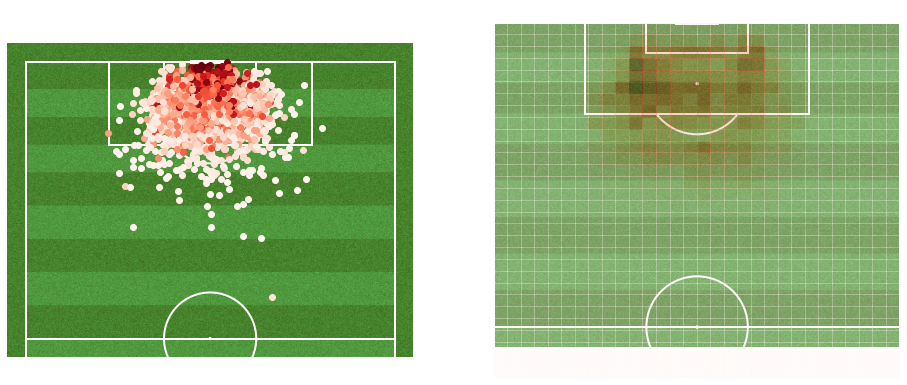

In [55]:
goals = shots.loc[shots['outcome'] == 'Goal']

cmap = plt.cm.Reds

cNorm  = colors.Normalize(vmin=goals['xg'].min(), vmax=goals['xg'].max())

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))


pitch = Pitch(pitch_color='grass', line_color='white', orientation='vertical', view='half', stripe=True, figsize=(12, 8))
pitch.draw(ax=ax[0])

for i, row in goals.iterrows():
    colorVal = scalarMap.to_rgba(row['xg'])
    ax[0].scatter(row['y_shot'], row['x_shot'], color=colorVal)
ax[0].set_title('Only goals', color='w')


pitch = Pitch(pitch_color='grass', line_color='white', orientation='vertical', view='half', stripe=True, figsize=(12, 8))
pitch.draw(ax=ax[1])

ax[1].hist2d(shots['y_shot'], shots['x_shot'], cmap=cmap, alpha=0.3, bins=30, range=[[0, 80], [50, 120]])
ax[1].set_title('All shots', color='w')    
    
plt.show()

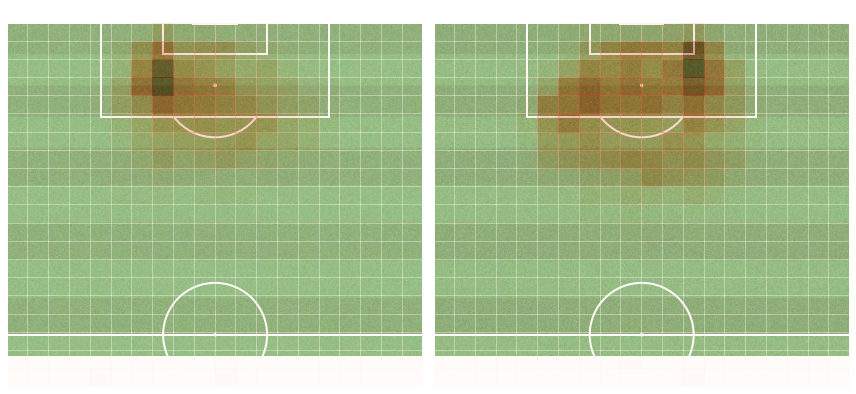

In [56]:
# Per body part

pitch = Pitch(pitch_color='grass', line_color='white', orientation='vertical', view='half', stripe=True, figsize=(12, 8), layout=(1, 2))
fig, ax = pitch.draw()


ax[0].hist2d(shots.loc[shots['body_part'] == 'Left Foot', 'y_shot'],
                shots.loc[shots['body_part'] == 'Left Foot', 'x_shot'],
                cmap='Reds', alpha=0.4, bins=(20, 20), range=[[0, 80], [50, 120]])
ax[0].set_title('Left foot', color='white')


ax[1].hist2d(shots.loc[shots['body_part'] == 'Right Foot', 'y_shot'],
                shots.loc[shots['body_part'] == 'Right Foot', 'x_shot'],
                cmap='Reds', alpha=0.4, bins=(20, 20), range=[[0, 80], [50, 120]])
ax[1].set_title('Right foot', color='white')


plt.show()

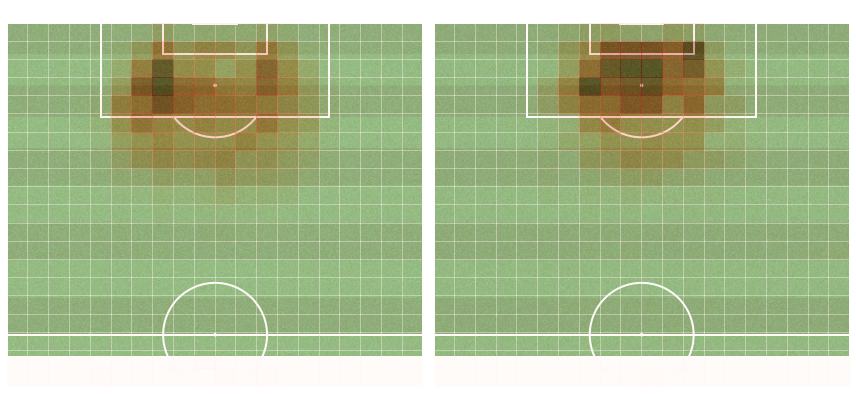

In [57]:
# Per technique

pitch = Pitch(pitch_color='grass', line_color='white', orientation='vertical', view='half', stripe=True, figsize=(12, 8), layout=(1, 2))
fig, ax = pitch.draw()


ax[0].hist2d(shots.loc[shots['technique'] == 'Normal', 'y_shot'],
                shots.loc[shots['technique'] == 'Normal', 'x_shot'],
                cmap='Reds', alpha=0.4, bins=(20, 20), range=[[0, 80], [50, 120]])
ax[0].set_title('Normal', color='white')


ax[1].hist2d(shots.loc[shots['technique'] != 'Normal', 'y_shot'],
                shots.loc[shots['technique'] != 'Normal', 'x_shot'],
                cmap='Reds', alpha=0.4, bins=(20, 20), range=[[0, 80], [50, 120]])
ax[1].set_title('Other', color='white')

plt.show()

What is the actual log-likelihood of the Statsbomb model on La Liga matches?

In [58]:
# Minus because the sklearn functions returns the NEGATIVE log-likelihood
print('Overall log-likelihood: ', -log_loss(shots['goal'], shots['xg']))

# Does it change between seasons?
print('\nSplit by season')
seasons = pd.merge(shots[['goal', 'xg', 'match_id']], matches[['match_id', 'season.season_name']], on='match_id')
display(seasons.groupby('season.season_name').apply(lambda x: -log_loss(x['goal'], x['xg'])))

Overall log-likelihood:  -0.30243423430985594

Split by season


season.season_name
2004/2005   -0.379349
2005/2006   -0.259710
2006/2007   -0.254142
2007/2008   -0.271446
2008/2009   -0.333375
2009/2010   -0.304810
2010/2011   -0.295682
2011/2012   -0.297212
2012/2013   -0.389431
2013/2014   -0.283313
2014/2015   -0.294736
2015/2016   -0.283390
2016/2017   -0.338357
2017/2018   -0.270894
2018/2019   -0.307242
2019/2020   -0.322595
dtype: float64

## xG model

#### Feature engineering

In [6]:
def isInside(x1, y1, x2, y2, x3, y3, x, y):
 
    a = ((y2 - y3)*(x - x3) + (x3 - x2)*(y - y3)) / ((y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3))
    b = ((y3 - y1)*(x - x3) + (x1 - x3)*(y - y3)) / ((y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3))
    c = 1 - a - b
     
    # Check if sum of A1, A2 and A3
    # is same as A
    if (0 <= a <= 1) and (0 <= b <= 1) and (0 <= c <= 1):
        return True
    else:
        return False

In [7]:
df = shots.copy()

df['y_center'] = np.abs(df['y_shot'] - 40)

df['distance'] = np.sqrt((120 - df['x_shot']) ** 2 + df['y_center'] ** 2)
# 8 is the width of the goal post
df['angle'] = np.arctan(
    8 * df['x_shot'] /
    (df['x_shot'] ** 2 + df['y_center'] ** 2 - (8/2)**2)
)
df.loc[df['angle'] < 0, 'angle'] += np.pi

# Analyze the key pass
df['has_key_pass'] = 1
df.loc[df['key_pass'].isnull(), 'has_key_pass'] = 0

df['distance_before_shot'] = np.sqrt(
    (df['x_shot'] - df['x_pass_received']) ** 2 +
    (df['y_shot'] - df['y_pass_received']) ** 2
)
df['distance_before_shot'].fillna(df['distance_before_shot'].mean(), inplace=True)

df['is_high_pass'] = 0
df.loc[df['pass_height'] == 'High Pass', 'is_high_pass'] = 1

# Working on freeze frame
# Number of players into the "goal cone"
df['players_between'] = df.apply(lambda x: np.sum([isInside(x['x_shot'], x['y_shot'], 120, 36, 120, 44,
                                                            item['location'][0], item['location'][1])
                                                   for item in x['freeze_frame']]) if x['freeze_frame'] is not None else None, 1)

# Number of opponents
df['opponents_between'] = df.apply(lambda x: np.sum([isInside(x['x_shot'], x['y_shot'], 120, 36, 120, 44,
                                                              item['location'][0], item['location'][1])
                                                     for item in x['freeze_frame'] if not item['teammate']])
                                             if x['freeze_frame'] is not None else None, 1)

# Is goalkeeper in goal cone
df['is_there_goalkeeper'] = df.apply(lambda x: np.max([isInside(x['x_shot'], x['y_shot'], 120, 36, 120, 44,
                                                                item['location'][0], item['location'][1])
                                                       and item['position']['name'] == 'Goalkeeper'
                                                       for item in x['freeze_frame'] if not item['teammate']]).astype(int)
                                               if x['freeze_frame'] is not None else None, 1)

# Distance to nearest opponent
df['tmp'] = df.apply(lambda x: [(x['x_shot'] - item['location'][0]) ** 2 + (x['y_shot'] - item['location'][1]) ** 2
                                for item in x['freeze_frame'] if not item['teammate'] and x['y_shot'] < item['location'][1]]
                               if x['freeze_frame'] is not None else [], 1)
df['nearest_opponent'] = df.apply(lambda x: np.sqrt(np.min(x['tmp'])) if len(x['tmp']) > 0 else None, 1)
df['nearest_opponent'].fillna(df['nearest_opponent'].mean(), inplace=True)

# Drop unused features
df.drop(['id', 'match_id', 'team_id', 'x_shot_end', 'y_shot_end', 'body_part', 'outcome',
            'shot_type', 'player_role', 'freeze_frame', 'key_pass', 'xg', 'pass_height',
            'pass_minute', 'pass_second', 'x_pass_received', 'y_pass_received', 'tmp']
           , 1, inplace=True)

print(df.shape)
df.head()

<ipython-input-6-fea486967789>:3: RuntimeWarning: divide by zero encountered in double_scalars
  a = ((y2 - y3)*(x - x3) + (x3 - x2)*(y - y3)) / ((y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3))
<ipython-input-6-fea486967789>:4: RuntimeWarning: divide by zero encountered in double_scalars
  b = ((y3 - y1)*(x - x3) + (x1 - x3)*(y - y3)) / ((y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3))
<ipython-input-6-fea486967789>:5: RuntimeWarning: invalid value encountered in double_scalars
  c = 1 - a - b
<ipython-input-6-fea486967789>:3: RuntimeWarning: invalid value encountered in double_scalars
  a = ((y2 - y3)*(x - x3) + (x3 - x2)*(y - y3)) / ((y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3))
<ipython-input-6-fea486967789>:4: RuntimeWarning: invalid value encountered in double_scalars
  b = ((y3 - y1)*(x - x3) + (x1 - x3)*(y - y3)) / ((y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3))


(9396, 15)


,x_shot,y_shot,technique,play_pattern,goal,y_center,distance,angle,has_key_pass,distance_before_shot,is_high_pass,players_between,opponents_between,is_there_goalkeeper,nearest_opponent
0,83.5,29.2,Half Volley,From Free Kick,0,10.8,38.064288,0.094166,0,7.633028,0,1,1,1,1.555635
1,110.4,54.2,Normal,From Free Kick,0,14.2,17.140595,0.071256,1,27.585685,0,1,1,1,10.907795
2,93.2,24.1,Normal,From Throw In,0,15.9,31.161675,0.083365,1,7.186793,0,1,1,1,2.906888
3,108.1,53.1,Normal,Regular Play,0,13.1,17.698022,0.072904,1,17.705366,1,2,2,1,10.024470
4,100.7,36.6,Normal,From Counter,0,3.4,19.597194,0.079312,1,46.856910,0,2,2,1,4.026164


#### Exploratory analysis

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x_shot,9396.0,103.476320,8.664204,45.300000,97.900000,104.500000,110.000000,120.000000
y_shot,9396.0,39.292060,10.579358,2.200000,30.400000,39.100000,48.100000,78.500000
goal,9396.0,0.136122,0.342936,0.000000,0.000000,0.000000,0.000000,1.000000
y_center,9396.0,8.986079,5.627240,0.000000,4.300000,8.900000,12.700000,38.500000
distance,9396.0,19.796656,8.282767,0.700000,13.859293,18.943337,25.026586,81.443539
angle,9396.0,0.077022,0.007089,0.065341,0.072013,0.075675,0.080682,0.155285
has_key_pass,9396.0,0.758727,0.427878,0.000000,1.000000,1.000000,1.000000,1.000000
distance_before_shot,9396.0,7.633028,7.393290,0.000000,2.817801,7.259476,7.633028,74.115653
is_high_pass,9396.0,0.142720,0.349806,0.000000,0.000000,0.000000,0.000000,1.000000
players_between,9396.0,1.638250,1.031562,0.000000,1.000000,1.000000,2.000000,10.000000


In [40]:
df.corr()['goal']

x_shot                  0.250878
y_shot                  0.019459
goal                    1.000000
y_center               -0.207839
distance               -0.312946
angle                  -0.210020
has_key_pass            0.001152
distance_before_shot   -0.053538
is_high_pass           -0.010239
players_between        -0.181829
opponents_between      -0.201052
is_there_goalkeeper    -0.225632
nearest_opponent       -0.030161
Name: goal, dtype: float64

### First model - Log Regression adding one variable at a time

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [34]:
# Add distance
test_model = smf.glm(formula="goal ~ distance", data=df, family=sm.families.Binomial()).fit()
print(test_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 9396
Model:                            GLM   Df Residuals:                     9394
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3148.2
Date:                Fri, 30 Apr 2021   Deviance:                       6296.4
Time:                        08:42:16   Pearson chi2:                 1.26e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8938      0.087     10.241      0.0

In [35]:
# Add angle + interaction with distance
test_model = smf.glm(formula="goal ~ distance + angle", data=df, family=sm.families.Binomial()).fit()
print(test_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 9396
Model:                            GLM   Df Residuals:                     9393
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3101.7
Date:                Fri, 30 Apr 2021   Deviance:                       6203.5
Time:                        08:42:17   Pearson chi2:                 1.05e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.9082      0.934     -8.471      0.0

In [36]:
# Add x shot coordinate
test_model = smf.glm(formula="goal ~ distance * angle + x_shot", data=df, family=sm.families.Binomial()).fit()
print(test_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 9396
Model:                            GLM   Df Residuals:                     9391
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3088.4
Date:                Fri, 30 Apr 2021   Deviance:                       6176.9
Time:                        08:42:17   Pearson chi2:                 9.70e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         77.4399     12.739      6.

In [37]:
# Check if it's better number of players in goal cone...
test_model = smf.glm(formula="goal ~ distance * angle + x_shot + players_between", data=df, family=sm.families.Binomial()).fit()
print(test_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 9396
Model:                            GLM   Df Residuals:                     9390
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3000.2
Date:                Fri, 30 Apr 2021   Deviance:                       6000.4
Time:                        08:42:18   Pearson chi2:                 1.03e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          76.3225     13.478     

In [38]:
# ... or simply number of opponents
test_model = smf.glm(formula="goal ~ distance * angle + x_shot + opponents_between", data=df, family=sm.families.Binomial()).fit()
print(test_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 9396
Model:                            GLM   Df Residuals:                     9390
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2978.4
Date:                Fri, 30 Apr 2021   Deviance:                       5956.8
Time:                        08:42:18   Pearson chi2:                 1.01e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            77.9772     13.57

In [39]:
# Is there goalkeeper in goal cone?
test_model = smf.glm(formula="goal ~ distance * angle + x_shot + opponents_between + is_there_goalkeeper", data=df, family=sm.families.Binomial()).fit()
print(test_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 9396
Model:                            GLM   Df Residuals:                     9389
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2969.3
Date:                Fri, 30 Apr 2021   Deviance:                       5938.5
Time:                        08:42:19   Pearson chi2:                 9.98e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              79.7522    

In [40]:
# Add distance to nearest opponent
test_model = smf.glm(formula="goal ~ distance * angle + x_shot + opponents_between + is_there_goalkeeper + nearest_opponent",
                     data=df, family=sm.families.Binomial()).fit()
print(test_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 9396
Model:                            GLM   Df Residuals:                     9388
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2965.5
Date:                Fri, 30 Apr 2021   Deviance:                       5930.9
Time:                        08:42:19   Pearson chi2:                 9.99e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              82.6951    

In [41]:
# Add if previous pass was high
test_model = smf.glm(formula="goal ~ distance * angle + x_shot + opponents_between + is_there_goalkeeper +" + 
                              "nearest_opponent + is_high_pass",
                     data=df, family=sm.families.Binomial()).fit()
print(test_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 9396
Model:                            GLM   Df Residuals:                     9387
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2955.5
Date:                Fri, 30 Apr 2021   Deviance:                       5911.0
Time:                        08:42:20   Pearson chi2:                 1.01e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              82.9118    

In [42]:
# Add technique (category)
test_model = smf.glm(formula="goal ~ distance * angle + x_shot + opponents_between + is_there_goalkeeper +" + 
                              "nearest_opponent + is_high_pass + C(technique)",
                     data=df, family=sm.families.Binomial()).fit()
print(test_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 9396
Model:                            GLM   Df Residuals:                     9382
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2918.2
Date:                Fri, 30 Apr 2021   Deviance:                       5836.5
Time:                        08:42:20   Pearson chi2:                 1.02e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [43]:
# Add play pattern (category)
test_model = smf.glm(formula="goal ~ distance * angle + x_shot + opponents_between + is_there_goalkeeper +" + 
                              "nearest_opponent + is_high_pass + C(technique) + C(play_pattern)",
                     data=df, family=sm.families.Binomial()).fit()
print(test_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 9396
Model:                            GLM   Df Residuals:                     9374
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2912.5
Date:                Fri, 30 Apr 2021   Deviance:                       5825.0
Time:                        08:42:21   Pearson chi2:                 1.02e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [44]:
logreg_xg = test_model.predict(df)

print('Log loss: ', -log_loss(df['goal'], logreg_xg))
logreg_xg.describe()

Log loss:  -0.309971732416862


count    9396.000000
mean        0.136122
std         0.156843
min         0.000023
25%         0.031022
50%         0.077543
75%         0.180966
max         0.917777
dtype: float64

### Another model - Gradient Boosting

In [9]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

Init signature:
CatBoostClassifier(
    iterations=None,
    learning_rate=None,
    depth=None,
    l2_leaf_reg=None,
    model_size_reg=None,
    rsm=None,
    loss_function=None,
    border_count=None,
    feature_border_type=None,
    per_float_feature_quantization=None,
    input_borders=None,
    output_borders=None,
    fold_permutation_block=None,
    od_pval=None,
    od_wait=None,
    od_type=None,
    nan_mode=None,
    counter_calc_method=None,
    leaf_estimation_iterations=None,
    leaf_estimation_method=None,
    thread_count=None,
    random_seed=None,
    use_best_model=None,
    best_model_min_trees=None,
    verbose=None,
    silent=None,
    logging_level=None,
    metric_period=None,
    ctr_leaf_count_limit=None,
    store_all_simple_ctr=None,
    max_ctr_complexity=None,
    has_time=None,
    allow_const_label=None,
    target_border=None,
    classes_count=None,
    class_weights=None,
    auto_class_weights=None,
    class_names=None,
    one_hot_max_size=Non

In [27]:
train, test, y_train, y_test = train_test_split(df.drop('goal', 1), df['goal'],
                                                test_size=0.1, random_state=1123, stratify=df['goal'])
train, valid, y_train, y_valid = train_test_split(train, y_train,
                                                  test_size=0.22, random_state=1123, stratify=y_train)
print(train.shape, valid.shape, test.shape)
print(y_train.mean(), y_valid.mean(), y_test.mean())

(6595, 14) (1861, 14) (940, 14)
0.13616376042456407 0.13594841483073616 0.13617021276595745


In [48]:
gboost = CatBoostClassifier(random_seed=1123, simple_ctr='BinarizedTargetMeanValue:Prior=0.13', l2_leaf_reg=10, subsample=0.6, depth=3, rsm=0.4)
gboost.fit(train, y_train, cat_features=['technique', 'play_pattern'], eval_set=(valid, y_valid))

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.


0:	learn: 0.6676569	test: 0.6678318	best: 0.6678318 (0)	total: 2.93ms	remaining: 2.92s
1:	learn: 0.6432814	test: 0.6437634	best: 0.6437634 (1)	total: 5.98ms	remaining: 2.98s
2:	learn: 0.6186420	test: 0.6193739	best: 0.6193739 (2)	total: 8.39ms	remaining: 2.79s
3:	learn: 0.5974213	test: 0.5985191	best: 0.5985191 (3)	total: 10.9ms	remaining: 2.71s
4:	learn: 0.5783857	test: 0.5796873	best: 0.5796873 (4)	total: 13.6ms	remaining: 2.7s
5:	learn: 0.5620465	test: 0.5634914	best: 0.5634914 (5)	total: 16.5ms	remaining: 2.74s
6:	learn: 0.5450164	test: 0.5467578	best: 0.5467578 (6)	total: 18.7ms	remaining: 2.65s
7:	learn: 0.5288187	test: 0.5310411	best: 0.5310411 (7)	total: 20.9ms	remaining: 2.59s
8:	learn: 0.5166254	test: 0.5187372	best: 0.5187372 (8)	total: 23.6ms	remaining: 2.6s
9:	learn: 0.5042843	test: 0.5062255	best: 0.5062255 (9)	total: 26.2ms	remaining: 2.59s
10:	learn: 0.4931262	test: 0.4952474	best: 0.4952474 (10)	total: 29.1ms	remaining: 2.62s
11:	learn: 0.4820537	test: 0.4842730	best: 

In [47]:
gb_xg = gboost.predict_proba(train)[:, 1]
gb_xg_valid = gboost.predict_proba(valid)[:, 1]
gb_xg_test = gboost.predict_proba(test)[:, 1]

print('Train log loss: ', -log_loss(y_train, gb_xg))
print('Valid log loss: ', -log_loss(y_valid, gb_xg_valid))
print('Test log loss: ', -log_loss(y_test, gb_xg_test))

Train log loss:  -0.2960997580924146
Valid log loss:  -0.3143655263877041
Test log loss:  -0.3274506727711258
